<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/models/Kaggle_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task: predict client churn

## imports

In [220]:
%%capture
!pip install shap

In [304]:
import pandas as pd
import numpy as np
import seaborn as sns
import shap

from matplotlib import pyplot as plt
from scipy.stats import boxcox
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, ShuffleSplit
from sklearn.preprocessing import StandardScaler

## download dataset

In [2]:
%%capture
!gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
!gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv
!gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y  # submission.csv

### upload df using pandas

In [325]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

### Freeze seeds

In [372]:
np.random.seed(42)

## EDA

In [6]:
train_df.head(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [94]:
print('train:', train_df.shape)
print('test:', test_df.shape)

train: (5282, 20)
test: (1761, 19)


### Check for NaNs

<Axes: >

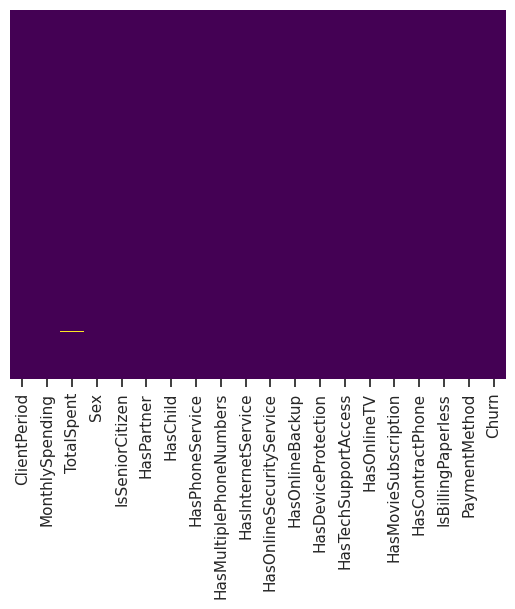

In [326]:
nandf = train_df.copy()
for col in nandf.columns:
  nandf[col] = nandf[col].replace(' ', np.NaN)
sns.heatmap(nandf.isna(), cbar=False, cmap='viridis', yticklabels=False)#, mask = (nandf[nacols]==0))

Some NaNs in TotalSpent

## Check duplicates

In [310]:
train_df.duplicated().sum()

14

In [327]:
train_df.drop_duplicates(inplace=True)

In [328]:
nochurn = train_df.drop(['Churn'], axis=1)
train_df[nochurn.duplicated(keep=False)].sort_values(by=[*train_df.columns])
train_df.drop_duplicates(subset=list(nochurn), keep='last', inplace=True)

### Check distirbution of target

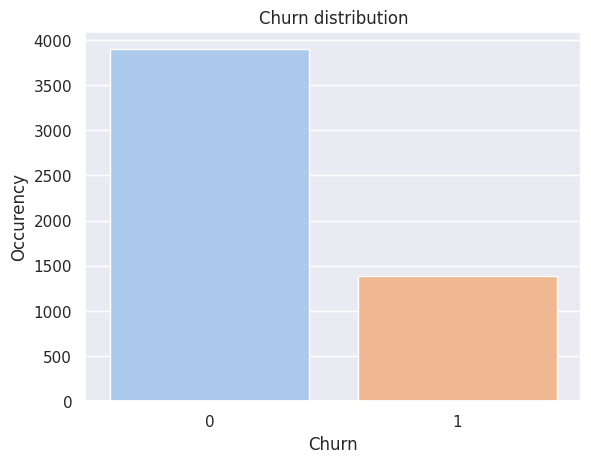

In [130]:
sns.set(style="darkgrid")
sns.set_palette('pastel')
sns.countplot(data=train_df, x='Churn')

plt.title('Churn distribution')
plt.xlabel('Churn')
plt.ylabel('Occurency')
plt.show()

Large class disbalance. We could possibly use undersampling or other techniques like generating synthetic data to solve this issue.

### Check columns

In [329]:
numeric_cols = [col for col in train_df.columns if train_df[col].dtype != 'object']
cat_cols = [col for col in train_df.columns if train_df[col].dtype == 'object']
print(f'Numneric: {numeric_cols}\nCategorial: {cat_cols}')

Numneric: ['ClientPeriod', 'MonthlySpending', 'IsSeniorCitizen', 'Churn']
Categorial: ['TotalSpent', 'Sex', 'HasPartner', 'HasChild', 'HasPhoneService', 'HasMultiplePhoneNumbers', 'HasInternetService', 'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription', 'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod']


In [95]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [128]:
pd.set_option('display.precision', 3)
train_df.describe()

,ClientPeriod,MonthlySpending,IsSeniorCitizen,Churn
count,5282.000,5282.000,5282.000,5282.000
mean,32.397,64.925,0.159,0.262
std,24.550,30.176,0.366,0.440
min,0.000,18.250,0.000,0.000
25%,9.000,35.463,0.000,0.000
50%,29.000,70.400,0.000,0.000
75%,55.000,90.050,0.000,1.000
max,72.000,118.750,1.000,1.000


In [104]:
train_df.nunique()

ClientPeriod                  73
MonthlySpending             1468
TotalSpent                  4982
Sex                            2
IsSeniorCitizen                2
HasPartner                     2
HasChild                       2
HasPhoneService                2
HasMultiplePhoneNumbers        3
HasInternetService             3
HasOnlineSecurityService       3
HasOnlineBackup                3
HasDeviceProtection            3
HasTechSupportAccess           3
HasOnlineTV                    3
HasMovieSubscription           3
HasContractPhone               3
IsBillingPaperless             2
PaymentMethod                  4
Churn                          2
dtype: int64

In [97]:
for col in numeric_cols:
  print(col, train_df[col].nunique())

ClientPeriod 73
MonthlySpending 1468
IsSeniorCitizen 2
Churn 2


In [98]:
for col in cat_cols:
  print(col, train_df[col].nunique())

TotalSpent 4978
Sex 2
HasPartner 2
HasChild 2
HasPhoneService 2
HasMultiplePhoneNumbers 3
HasInternetService 3
HasOnlineSecurityService 3
HasOnlineBackup 3
HasDeviceProtection 3
HasTechSupportAccess 3
HasOnlineTV 3
HasMovieSubscription 3
HasContractPhone 3
IsBillingPaperless 2
PaymentMethod 4


In [105]:
for col in cat_cols[1:]:
  print(col, train_df[col].unique())

Sex ['Male' 'Female']
HasPartner ['Yes' 'No']
HasChild ['Yes' 'No']
HasPhoneService ['Yes' 'No']
HasMultiplePhoneNumbers ['No' 'Yes' 'No phone service']
HasInternetService ['No' 'Fiber optic' 'DSL']
HasOnlineSecurityService ['No internet service' 'No' 'Yes']
HasOnlineBackup ['No internet service' 'No' 'Yes']
HasDeviceProtection ['No internet service' 'No' 'Yes']
HasTechSupportAccess ['No internet service' 'Yes' 'No']
HasOnlineTV ['No internet service' 'No' 'Yes']
HasMovieSubscription ['No internet service' 'No' 'Yes']
HasContractPhone ['One year' 'Two year' 'Month-to-month']
IsBillingPaperless ['No' 'Yes']
PaymentMethod ['Mailed check' 'Credit card (automatic)' 'Electronic check'
 'Bank transfer (automatic)']


#### We already have "HasPhoneService" and 'HasInternetService'. Avoid mutlicolinearity

In [330]:
no_internet_service_cols = [
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription']

for col in no_internet_service_cols:
    train_df[col] = train_df[col].replace('No internet service', 'No')

train_df['HasMultiplePhoneNumbers'] = train_df['HasMultiplePhoneNumbers'].replace('No phone service', 'No')

Basically custom Label encoder becoming OHE but with a single value 1 so we don't need two cols

In [331]:
for col in cat_cols:
  uniques = train_df[col].unique()
  if len(uniques) == 2:
    train_df[col] = train_df[col].replace({uniques[0]:0, uniques[1]: 1})

In [332]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5260 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5260 non-null   int64  
 1   MonthlySpending           5260 non-null   float64
 2   TotalSpent                5260 non-null   object 
 3   Sex                       5260 non-null   int64  
 4   IsSeniorCitizen           5260 non-null   int64  
 5   HasPartner                5260 non-null   int64  
 6   HasChild                  5260 non-null   int64  
 7   HasPhoneService           5260 non-null   int64  
 8   HasMultiplePhoneNumbers   5260 non-null   int64  
 9   HasInternetService        5260 non-null   object 
 10  HasOnlineSecurityService  5260 non-null   int64  
 11  HasOnlineBackup           5260 non-null   int64  
 12  HasDeviceProtection       5260 non-null   int64  
 13  HasTechSupportAccess      5260 non-null   int64  
 14  HasOnlin

## Convert values to use less memory

In [333]:
def convert_dtype(data):
  for col in data.columns:
    if data[col].dtype == 'float64':
      data[col] = data[col].astype('float32')

    elif data[col].dtype == 'int64':
      data[col] = data[col].astype('int32')
  return data

In [334]:
train_df = convert_dtype(train_df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5260 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5260 non-null   int32  
 1   MonthlySpending           5260 non-null   float32
 2   TotalSpent                5260 non-null   object 
 3   Sex                       5260 non-null   int32  
 4   IsSeniorCitizen           5260 non-null   int32  
 5   HasPartner                5260 non-null   int32  
 6   HasChild                  5260 non-null   int32  
 7   HasPhoneService           5260 non-null   int32  
 8   HasMultiplePhoneNumbers   5260 non-null   int32  
 9   HasInternetService        5260 non-null   object 
 10  HasOnlineSecurityService  5260 non-null   int32  
 11  HasOnlineBackup           5260 non-null   int32  
 12  HasDeviceProtection       5260 non-null   int32  
 13  HasTechSupportAccess      5260 non-null   int32  
 14  HasOnlin

825kb vs 495 might be of use

Something's wrong with TotalSpent column

In [336]:
train_df['TotalSpent'].count()

5260

In [337]:
train_df[train_df['TotalSpent'].str.isspace()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,0,0,0,0,0,1,No,0,0,0,0,0,0,Two year,0,Mailed check,0
1707,0,73.35,,1,0,0,0,0,1,DSL,0,1,1,1,1,0,Two year,0,Mailed check,0
2543,0,19.70,,0,0,0,0,0,0,No,0,0,0,0,0,0,One year,1,Mailed check,0
3078,0,80.85,,1,0,0,0,0,0,DSL,1,1,1,0,1,1,Two year,0,Mailed check,0
3697,0,20.00,,1,0,0,0,0,0,No,0,0,0,0,0,0,Two year,0,Mailed check,0
4002,0,61.90,,0,0,1,0,0,1,DSL,1,1,0,1,0,0,Two year,1,Bank transfer (automatic),0
4326,0,25.35,,0,0,0,0,0,1,No,0,0,0,0,0,0,Two year,0,Mailed check,0
4551,0,52.55,,1,0,0,0,1,0,DSL,1,0,1,1,1,0,Two year,1,Bank transfer (automatic),0
4598,0,56.05,,1,0,0,0,1,0,DSL,1,1,1,1,1,0,Two year,0,Credit card (automatic),0


We make an educated guess that theese are our new clients

#### Fill the whitespace values with monthly spending and convert all vals to floats

In [338]:
train_df.loc[train_df['TotalSpent'].str.isspace(), 'TotalSpent'] = train_df.loc[train_df['TotalSpent'].str.isspace(), 'MonthlySpending']
train_df['TotalSpent'] = train_df['TotalSpent'].astype('float32')

## Feature engineering

First things first we can add avg monthly expenditure

In [341]:
train_df['AvgMonthlySpent'] = train_df['TotalSpent'] / (train_df['ClientPeriod']+1)

## Correlation matrix

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


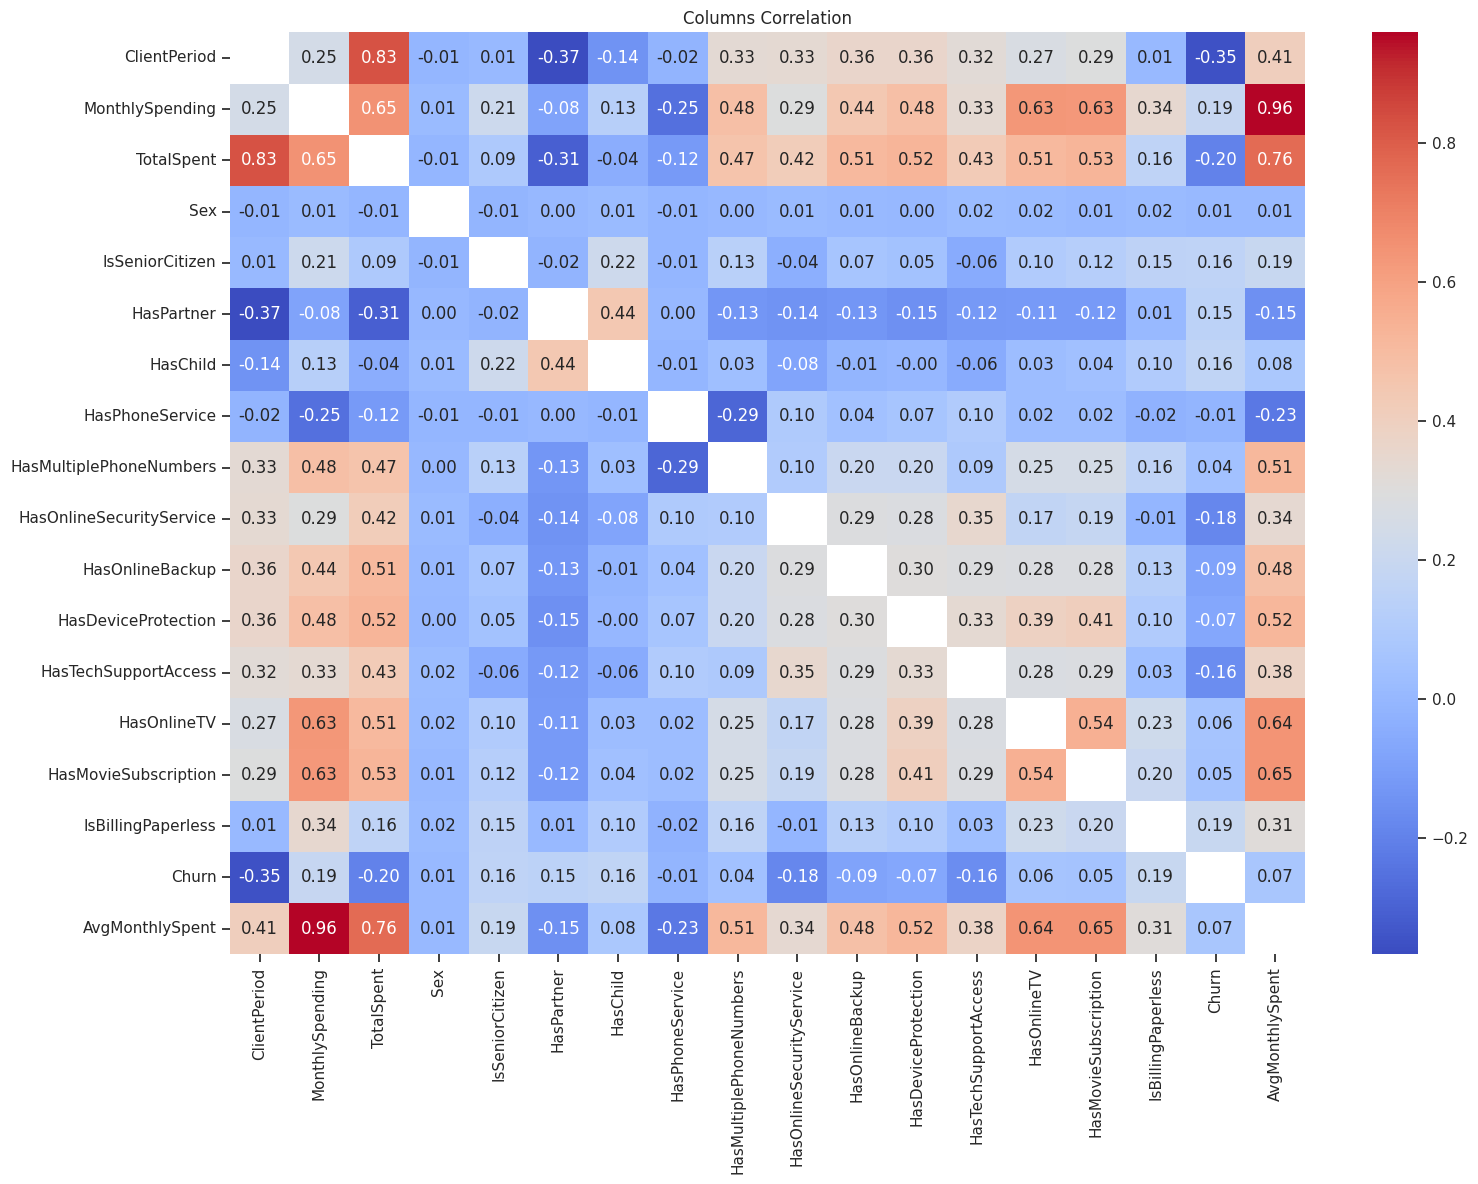

In [342]:
plt.figure(figsize=(16,12))

corr_matrix = train_df.corr()
np.fill_diagonal(corr_matrix.values, np.nan)
sns.heatmap(data=corr_matrix, annot=True, fmt = '.2f', cmap='coolwarm')
plt.title('Columns Correlation')
plt.tight_layout()

There is a strong correlation between total spendings and number of months being a client (no shyte Sherlock!) and having a TV and Movie subscriptions with monthly spenditure. As well as with other services, duh.

We are not gonna remove those.

## One-hot the 3+ unique vals

In [ ]:
columns_to_convert = ['HasInternetService', 'HasContractPhone', 'PaymentMethod']
train_df = pd.get_dummies(train_df, columns=columns_to_convert, drop_first=True)

In [345]:
train_df.describe()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasOnlineSecurityService,...,IsBillingPaperless,Churn,AvgMonthlySpent,HasInternetService_Fiber optic,HasInternetService_No,HasContractPhone_One year,HasContractPhone_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
count,5260.000,5260.000,5260.000,5260.000,5260.000,5260.00,5260.000,5260.000,5260.000,5260.000,...,5260.000,5260.000,5260.000,5260.000,5260.000,5260.000,5260.000,5260.000,5260.000,5260.000
mean,32.528,65.041,2296.977,0.497,0.160,0.51,0.695,0.099,0.428,0.291,...,0.597,0.261,59.397,0.444,0.214,0.206,0.243,0.217,0.338,0.224
std,24.517,30.153,2269.028,0.500,0.367,0.50,0.461,0.299,0.495,0.454,...,0.491,0.439,30.530,0.497,0.410,0.404,0.429,0.412,0.473,0.417
min,0.000,18.250,18.800,0.000,0.000,0.00,0.000,0.000,0.000,0.000,...,0.000,0.000,9.183,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,9.000,35.738,403.300,0.000,0.000,0.00,0.000,0.000,0.000,0.000,...,0.000,0.000,26.290,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,29.000,70.500,1414.900,0.000,0.000,1.00,1.000,0.000,0.000,0.000,...,1.000,0.000,61.360,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,55.000,90.050,3813.713,1.000,0.000,1.00,1.000,0.000,1.000,1.000,...,1.000,1.000,85.419,1.000,0.000,0.000,0.000,0.000,1.000,0.000
max,72.000,118.750,8684.800,1.000,1.000,1.00,1.000,1.000,1.000,1.000,...,1.000,1.000,118.970,1.000,1.000,1.000,1.000,1.000,1.000,1.000


## Check for skewness

In [158]:
def check_skew(data):
  skewness = data.skew()
  sns.barplot(x=skewness.index, y=skewness)
  plt.xticks(rotation=90)
  plt.xlabel('Columns')
  plt.ylabel('Skewness')
  plt.title('Skewness of Columns')
  plt.show()


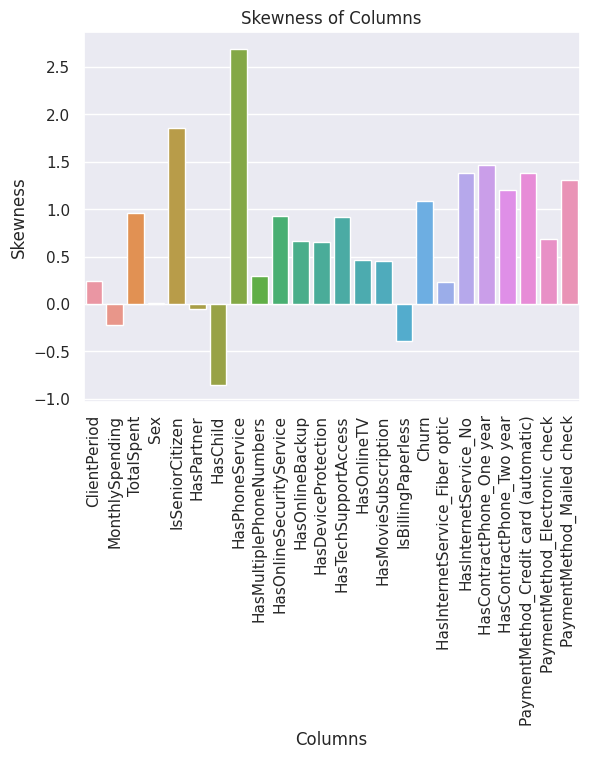

In [161]:
check_skew(train_df)

we can see that HasPhoneService is skewed to the right. As well as some other data. We would possibly want to log, sqrt, cude or boxcox transform it

<Axes: xlabel='HasPhoneService', ylabel='count'>

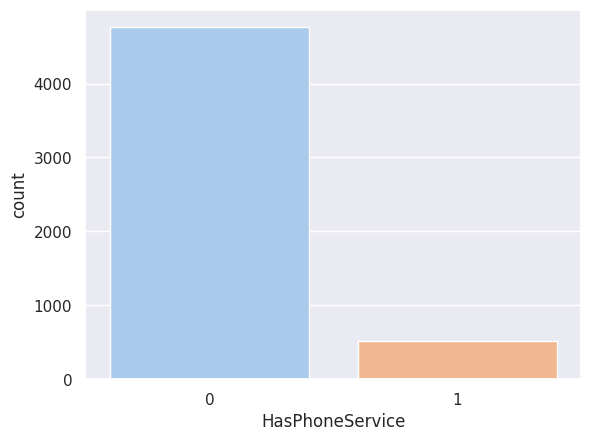

In [216]:
sns.countplot(data=train_df, x='HasPhoneService')

### Density plot

In [194]:
def plot_dist_dense(data, n=3):
  cols = [d for d in data.columns if len(data[d].unique()) > 2]
  fig, axes = plt.subplots(2, n, figsize=(14,6))
  colors = ['blue', 'green', 'orange', 'red', 'purple', 'cyan', 'magenta', 'yellow', 'brown']

  for num, column in enumerate(data[cols]):
    row = num // n
    col = num % n
    ax = axes[row, col]
    sns.histplot(data[column], kde=True, color=colors[num], ax=ax)
  plt.tight_layout()
  plt.show()

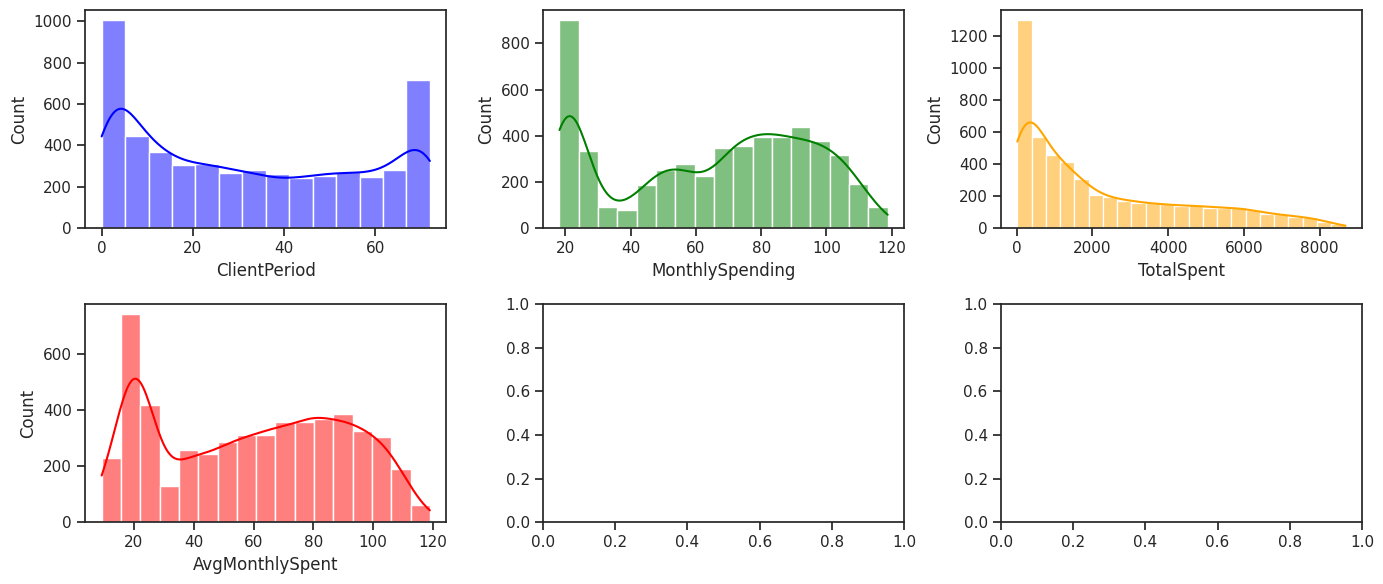

In [346]:
plot_dist_dense(train_df)

## Check outliers

In [347]:
multival_cols = ('ClientPeriod', 'MonthlySpending', 'TotalSpent', 'AvgMonthlySpent')

In [196]:
def check_outliers(df, name, size=4):
  sns.boxplot(x=df[name], linewidth=2, width=0.5, notch=True, palette='Blues')
  sns.swarmplot(x=df[name], color='black', size=size)
  plt.show()

In [197]:
def get_iqr(df, name, iqr=1.5, side=1):
  if side:
    iqr_result = df[name].describe()['75%'] * iqr
    new_df = df[df[name] > iqr_result]
  else:
    iqr_result = df[name].describe()['25%'] / iqr
    new_df = df[df[name] < iqr_result]
  display(new_df)
  return iqr_result

In [348]:
for col in multival_cols:
  print(get_iqr(train_df, col).shape)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasOnlineSecurityService,...,IsBillingPaperless,Churn,AvgMonthlySpent,HasInternetService_Fiber optic,HasInternetService_No,HasContractPhone_One year,HasContractPhone_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check


()


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasOnlineSecurityService,...,IsBillingPaperless,Churn,AvgMonthlySpent,HasInternetService_Fiber optic,HasInternetService_No,HasContractPhone_One year,HasContractPhone_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check


()


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasOnlineSecurityService,...,IsBillingPaperless,Churn,AvgMonthlySpent,HasInternetService_Fiber optic,HasInternetService_No,HasContractPhone_One year,HasContractPhone_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
4,60,115.25,6758.45,1,0,0,0,0,1,1,...,0,0,110.794,1,0,0,1,1,0,0
11,70,113.05,7869.05,1,0,0,0,0,1,1,...,1,0,110.832,1,0,0,1,1,0,0
12,69,99.50,6841.45,0,0,0,1,0,1,0,...,0,0,97.735,1,0,1,0,0,0,0
17,71,90.30,6287.30,0,0,0,0,0,1,1,...,0,0,87.324,0,0,0,1,1,0,0
24,55,104.15,5743.05,0,0,0,1,0,1,0,...,1,1,102.554,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5267,72,112.25,8041.65,0,0,0,0,0,1,0,...,1,0,110.160,1,0,0,1,0,0,0
5268,72,117.50,8670.10,1,0,0,0,0,1,1,...,0,0,118.768,1,0,0,1,1,0,0
5271,67,88.80,5903.15,0,0,1,1,0,1,1,...,1,0,86.811,0,0,1,0,0,0,0
5273,60,104.35,6339.45,0,1,0,1,0,1,0,...,1,0,103.925,1,0,1,0,0,1,0


()


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasOnlineSecurityService,...,IsBillingPaperless,Churn,AvgMonthlySpent,HasInternetService_Fiber optic,HasInternetService_No,HasContractPhone_One year,HasContractPhone_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check


()


TotalSpend definitelly has outliers

## Check transformations for multivar cols

In [349]:
def bxcx(df):
  result, _ = boxcox(df+1) #we add one in case of zero values
  return result

def plot_transforms(data, name):
  operations = [np.sqrt, np.cbrt, np.log, np.log1p]
  opernames = ['square root', 'cube root', 'log', 'log1p', 'boxcox']
  colors = ['magenta', 'blue','orange','indigo', 'red']
  fig, axes = plt.subplots(1, 5, figsize=(12,2))
  fig.suptitle(name)

  def plot_in_subplots(result, num):
    sns.histplot(result, kde=True, color = colors[num], ax=axes[num])
    axes[num].set_xlabel(opernames[num])
    axes[num].set_ylabel('')

  for num in range(4):
    result = data[name].apply(lambda x: operations[num](x))
    plot_in_subplots(result, num)

  result = bxcx(data[name])
  plot_in_subplots(result, 4)

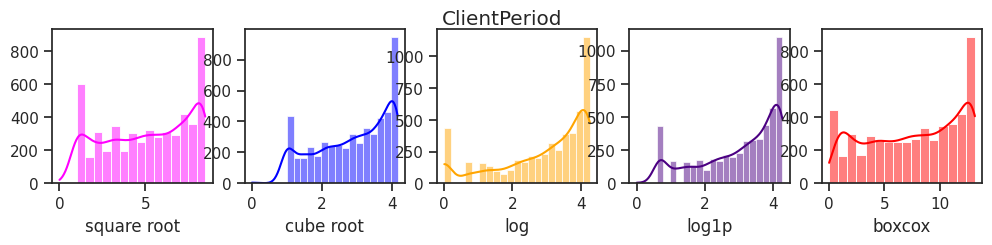

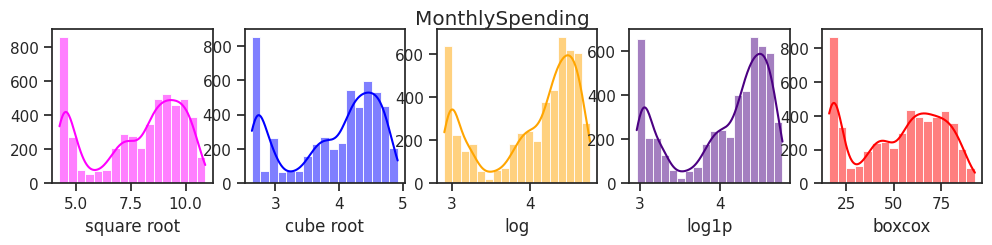

overflow encountered in multiply


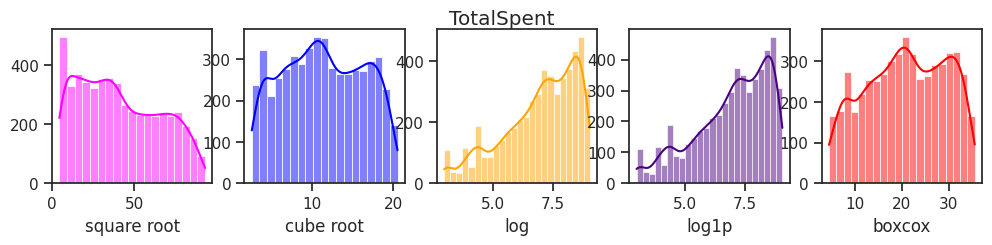

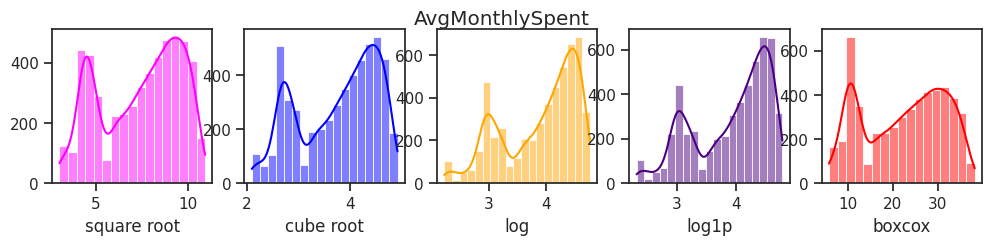

In [354]:
transformed_data = train_df.copy()
for col in multival_cols:
  plot_transforms(transformed_data, col)
  plt.show()

Looks like no trasnformation would affect MonthlySpending and ClientPeriod but it seems that boxcox or cube root would work for TotalSpent

#### Apply boxcox transformation

overflow encountered in multiply


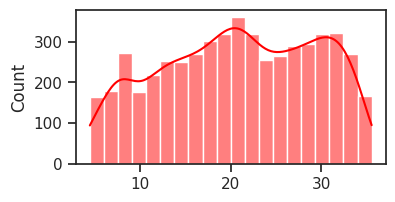

In [355]:
totalspent = train_df['TotalSpent'].copy()
totalspent = bxcx(totalspent)
plt.figure(figsize = (4,2))
sns.histplot(totalspent, kde=True, color = 'red')
transformed_data['TotalSpent'] = totalspent

In [356]:
avgmonth = train_df['AvgMonthlySpent'].copy()
avgmonth = np.log1p(avgmonth)
transformed_data['AvgMonthSpent'] = avgmonth
mon = train_df['MonthlySpending'].copy()
mon = np.sqrt(mon)
transformed_data['MonthlySpending'] = mon

#### Check for outliers after transformation

In [357]:
get_iqr(transformed_data, 'TotalSpent')

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasOnlineSecurityService,...,Churn,AvgMonthlySpent,HasInternetService_Fiber optic,HasInternetService_No,HasContractPhone_One year,HasContractPhone_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,AvgMonthSpent


42.16688561439514

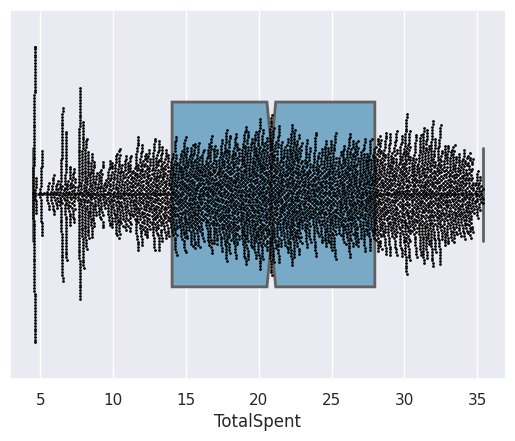

In [211]:
check_outliers(transformed_data, 'TotalSpent', size=2)

Check parameters relationships
Yohoho gonna take a while

In [ ]:
"""sns.set(style="ticks", color_codes=True)
palette = ['purple', 'red']#sns.color_palette("husl")
sns.pairplot(transformed_data, diag_kind="kde", hue="Churn", palette=palette, markers='o', diag_kws={'bw_adjust': 0.2})
plt.suptitle("Parameter relationships", y=1.02, fontsize=18)
sns.despine()
plt.tight_layout()
plt.show()"""

Nah, I got tired of waiting after 15 min. It's not worth it. We got correlation matrix after all

## Scale

In [358]:
nochurn = transformed_data.drop('Churn', axis=1)
trainscaler = StandardScaler()
trainscaler.fit(nochurn)

StandardScaler()

In [359]:
trainscaler.transform(nochurn)

array([[ 9.16650437e-01, -1.64680144e+00, -2.11744958e-01, ...,
        -7.15188264e-01,  1.86150349e+00, -1.52391193e+00],
       [ 1.61010381e+00, -1.32141898e+00,  2.38817788e-01, ...,
        -7.15188264e-01, -5.37200174e-01, -1.01858089e+00],
       [-1.28608380e+00,  4.44584443e-01, -1.52938810e+00, ...,
         1.39823324e+00, -5.37200174e-01, -4.21198641e-01],
       ...,
       [-1.28608380e+00, -1.84602390e-01, -1.63846598e+00, ...,
        -7.15188264e-01,  1.86150349e+00, -9.11384130e-01],
       [-1.43925309e-01,  4.47377370e-01,  3.77799741e-01, ...,
        -7.15188264e-01, -5.37200174e-01,  6.06539145e-01],
       [-5.51839057e-01,  4.44584443e-01, -8.31136079e-04, ...,
        -7.15188264e-01,  1.86150349e+00,  4.96341320e-01]])

## Check best parameters

In [360]:
def get_xy(df):
  df = df.copy()
  X = df.drop(['Churn'], axis=1)
  y = df['Churn']
  return X, y

### Select K-best

#### Chi squared

In [361]:
def get_kbest(df):
  X, y = get_xy(df)
  kbest = SelectKBest(score_func=chi2, k=4)
  kbest_trained = kbest.fit(X, y)
  return kbest_trained

def get_kbest_chi2_score(df):
  X, y = get_xy(df)
  kbest = SelectKBest(score_func=chi2, k=4)
  kbest_trained = kbest.fit(X, y)
  kbest_dict = dict(zip(df.drop('Churn', axis=1).columns, np.round(kbest_trained.scores_, 3)))
  sorted_kbest = dict(sorted(kbest_dict.items(), key=lambda i: i[1], reverse=True))

  print('Scores assigned by chi squared:')
  for col, val in sorted_kbest.items():
    print(f'{col}: {val}')
  print()

  print('Values of top most important features')
  features = kbest.transform(X)
  print(features[0:5, :])


In [362]:
get_kbest_chi2_score(transformed_data)

Scores assigned by chi squared:
ClientPeriod: 11847.128
TotalSpent: 962.637
AvgMonthlySpent: 402.47
HasContractPhone_Two year: 366.39
PaymentMethod_Electronic check: 306.125
HasInternetService_Fiber optic: 265.113
HasInternetService_No: 216.642
HasContractPhone_One year: 125.893
HasOnlineSecurityService: 123.199
MonthlySpending: 112.062
IsSeniorCitizen: 110.456
HasTechSupportAccess: 100.594
PaymentMethod_Credit card (automatic): 80.209
IsBillingPaperless: 79.888
HasPartner: 55.034
HasChild: 42.306
PaymentMethod_Mailed check: 31.113
HasOnlineBackup: 25.622
HasDeviceProtection: 15.335
HasOnlineTV: 12.367
HasMovieSubscription: 9.089
HasMultiplePhoneNumbers: 5.435
AvgMonthSpent: 4.499
HasPhoneService: 0.46
Sex: 0.166

Values of top most important features
[[ 55.          19.01752853  18.32767814   0.        ]
 [ 72.          22.8071022   25.64657467   1.        ]
 [  1.           7.93515253  37.95000076   0.        ]
 [ 32.          25.05053329  77.87878788   0.        ]
 [ 60.          33

#### RFE

In [363]:
def get_rfe(df, n_features=3):
  X, y = get_xy(df)
  model = LogisticRegression(max_iter=800)
  rfe = RFE(model, n_features_to_select=n_features)
  trained_rfe = rfe.fit(X, y)
  return trained_rfe

In [365]:
df_rfe = get_rfe(transformed_data)
rfe_stats = pd.DataFrame(zip(df_rfe.ranking_, df_rfe.support_),
                         index = nochurn.columns, columns=['DF ranking', 'DF feature']
                         ).sort_values(by='DF ranking')
rfe_stats

,DF ranking,DF feature
HasContractPhone_Two year,1,True
HasContractPhone_One year,1,True
HasInternetService_No,1,True
AvgMonthSpent,2,False
MonthlySpending,3,False
HasOnlineSecurityService,4,False
HasPhoneService,5,False
HasTechSupportAccess,6,False
HasOnlineBackup,7,False
IsBillingPaperless,8,False


### PCA

In [258]:
def get_pca(df, n=3):
  X, y = get_xy(df)
  pca = PCA(n_components=n)
  pca_fit = pca.fit(X, y)
  pca_trans = pca.transform(X)
  return pca_fit, pca_trans

def visualize_pca(df, pca_components=3):
  pca_fit, pca_t = get_pca(df, pca_components)
  pca_df = pd.DataFrame(data=pca_t, columns=['PC1', 'PC2', 'PC3'])

  components_df = pd.DataFrame(pca_fit.components_, index=[f"Component {i+1}" for i in range(pca_components)], columns=df.drop('Churn', axis=1
  ).columns)
  display(components_df)

  sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['PC3'])
  plt.show()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasOnlineSecurityService,...,HasOnlineTV,HasMovieSubscription,IsBillingPaperless,HasInternetService_Fiber optic,HasInternetService_No,HasContractPhone_One year,HasContractPhone_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
Component 1,0.251,0.382,0.364,0.006,0.089,-0.113,0.011,-0.031,0.223,0.184,...,0.289,0.292,0.142,0.234,-0.287,0.041,0.075,0.075,0.065,-0.201
Component 2,0.351,-0.198,0.191,-0.002,-0.191,-0.246,-0.269,0.075,-0.030,0.190,...,-0.054,-0.044,-0.214,-0.325,0.213,0.096,0.382,0.202,-0.364,0.110
Component 3,-0.167,-0.041,-0.113,0.008,-0.087,0.195,0.114,0.557,-0.391,0.266,...,0.078,0.087,-0.019,-0.242,-0.317,0.119,-0.183,-0.049,-0.005,0.097


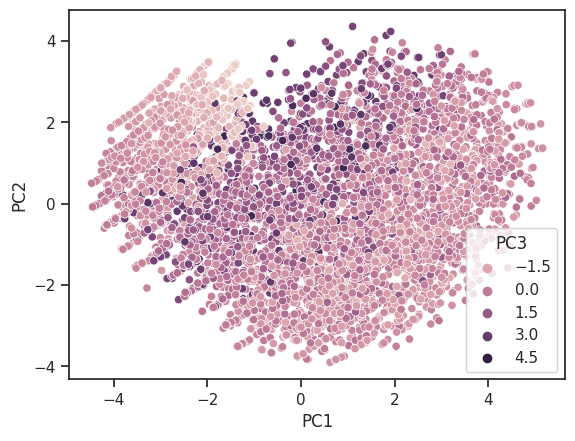

In [259]:
visualize_pca(transformed_data)

### Extremely random trees

In [299]:
def extratree_components(df, title):
  X,y = get_xy(df)
  X = trainscaler.transform(X)
  model = ExtraTreesClassifier()
  model.fit(X,y)
  treedf = pd.DataFrame(model.feature_importances_.reshape(1,-1), columns = [d for d in df.columns if d != 'Churn'], index=title)
  return treedf

In [366]:
df1 = extratree_components(transformed_data, ['importance'])
df1

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasOnlineSecurityService,...,IsBillingPaperless,AvgMonthlySpent,HasInternetService_Fiber optic,HasInternetService_No,HasContractPhone_One year,HasContractPhone_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,AvgMonthSpent
importance,0.117,0.086,0.107,0.035,0.025,0.029,0.025,0.007,0.023,0.03,...,0.03,0.084,0.046,0.023,0.029,0.04,0.016,0.036,0.014,0.084


### Permutation importance

In [262]:
def permute(model, X, y):
  score = model.score(X, y)
  feature_importance = {}
  for feature in X.columns:
    X_perm = X.copy()
    X_perm[feature] = np.random.permutation(X_perm[feature])
    perm_score = model.score(X_perm, y)
    feature_importance[feature] = score - perm_score
  return feature_importance

def get_permutations(df, model):
  X, y = get_xy(df)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  model.fit(X_train, y_train)
  permimp = permute(model, X_test, y_test)
  return permimp

In [368]:
for model in (LogisticRegression(max_iter=1000), RandomForestClassifier()):
  dic = get_permutations(transformed_data, model)
  result = pd.DataFrame([dic[n] for n in nochurn],
                        index = nochurn.columns, columns = ['importance']).T
  display(result)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasOnlineSecurityService,...,IsBillingPaperless,AvgMonthlySpent,HasInternetService_Fiber optic,HasInternetService_No,HasContractPhone_One year,HasContractPhone_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,AvgMonthSpent
importance,0.022,0.067,0.096,0.0,0.006,0.0,0.003,0.008,0.002,0.01,...,0.005,0.031,0.005,0.006,0.006,0.023,9.506e-04,-9.506e-04,0.0,0.04


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasOnlineSecurityService,...,IsBillingPaperless,AvgMonthlySpent,HasInternetService_Fiber optic,HasInternetService_No,HasContractPhone_One year,HasContractPhone_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,AvgMonthSpent
importance,0.02,9.506e-04,0.019,9.506e-04,0.006,0.008,0.0,-9.506e-04,-0.003,0.01,...,-9.506e-04,-0.01,0.023,-0.004,0.004,0.012,-0.004,0.003,0.002,-0.01


### SHAP

In [369]:
def get_shap(df):
  X, y = get_xy(df)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  model = RandomForestClassifier(n_estimators=50, max_depth=7, random_state=42)
  model.fit(X_train, y_train)
  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(X_test)
  shap.summary_plot(shap_values[1], X_test, plot_type = 'bar', title='TEXT') #somehow title='text' is not shown on the graph

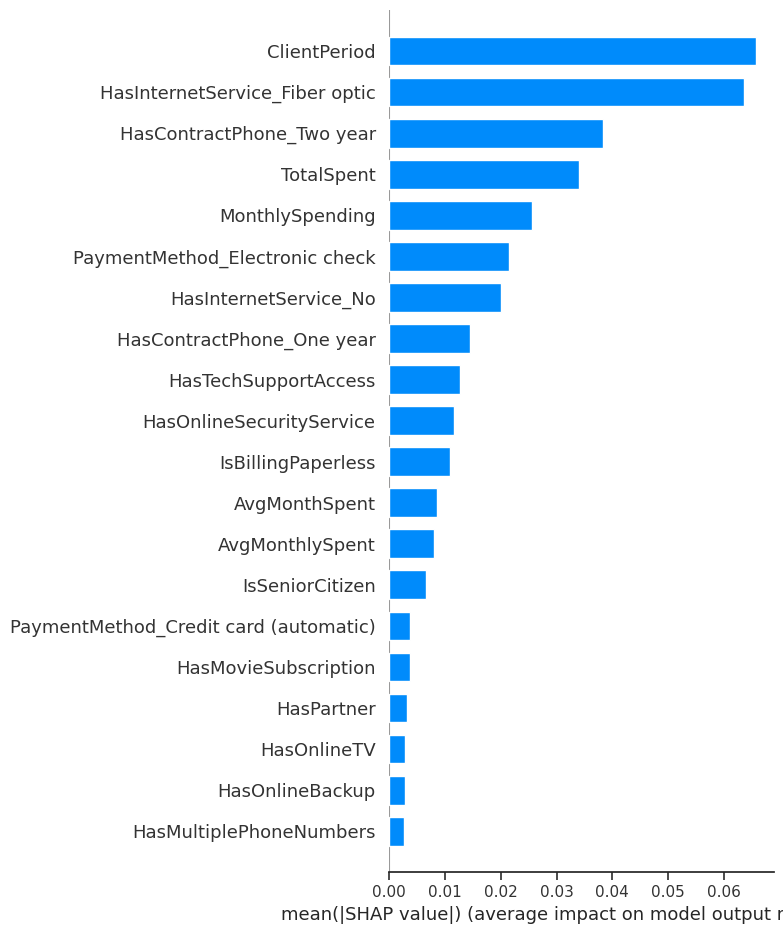

In [370]:
get_shap(transformed_data)

## Predict and evaluate data

In [305]:
def traintest(df):
  X, y = get_xy(df)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = RandomForestClassifier(n_estimators=100, max_depth=5, max_leaf_nodes=5, random_state=42)#LogisticRegression(max_iter=400)
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  eval_model(y_test, y_pred)
  return model


def eval_model(y_pred, y_test):
  print(f'Accuracy: {round(100*accuracy_score(y_test, y_pred), 2)}%\n')
  print(f'rocauc: {round(100*roc_auc_score(y_test, y_pred), 2)}%\n')

  print('Classification report:')
  cr=classification_report(y_test, y_pred, output_dict=True)
  show_cr(cr)
  show_cm(confusion_matrix(y_test, y_pred))


In [238]:
def show_cm(cm):
  plt.figure(figsize=(6,4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.tight_layout()
  plt.show()

def highlight_best(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

def show_cr(cr):
  report = pd.DataFrame(cr).transpose()
  report = report.round(2)
  report.style.apply(highlight_best, axis=1)
  display(report)

Accuracy: 77.28%

rocauc: 74.36%

Classification report:


,precision,recall,f1-score,support
0,0.95,0.78,0.86,933.00
1,0.29,0.71,0.41,119.00
accuracy,0.77,0.77,0.77,0.77
macro avg,0.62,0.74,0.64,1052.00
weighted avg,0.88,0.77,0.81,1052.00


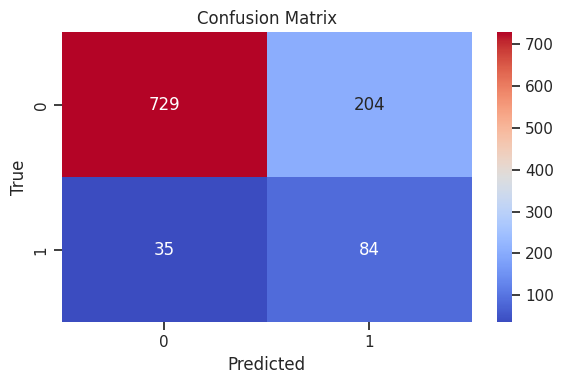

In [371]:
raw_model = traintest(transformed_data)